In [1]:
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader
import torch
import torchvision

import pandas as pd 
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

from src.data import DogBreedDataset, TrainTransform
from src.data import get_test_time_transform, get_train_time_transform_simple
from src.utils import show_data_batch
from src.model import initialize_model, get_model_input_size
from src.run import apply_model

## data inputs

In [3]:
# set the path and directory for validation and test
val_dataset_csv = 'processed_data/train_valid_dataset.csv'
test_dataset_csv = 'processed_data/test_dataset.csv'
train_root_dir = 'data/train'
test_root_dir = 'data/test'

## training settings

In [4]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = 'inception_v3'
input_size = get_model_input_size(model_name)

# Number of classes in the dataset
num_classes = 120

# Batch size for testing (change depending on how much memory you have)
batch_size = 32

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

## load datasets

In [5]:
crop_size = input_size
# we use (scale_size: 256, crop_size: 224) and (scale_size: 320, crop_size: 299)
# for resize and cropping
scale_size = 320 if input_size == 299 else 256

print('input size: {} scale size: {} crop size: {}'.format(input_size, scale_size, crop_size))

input size: 299 scale size: 320 crop size: 299


In [6]:
# transforms settings
test_transform = get_test_time_transform(scale_size=crop_size, crop_size=crop_size)

# use this for test time augmentation
train_transfrom = get_train_time_transform_simple(scale_size=scale_size, crop_size=crop_size)

In [7]:
# datasets with transforms
val_dataset = DogBreedDataset(
    csv_file=val_dataset_csv, root_dir=train_root_dir, transform=test_transform)
test_dataset = DogBreedDataset(
    csv_file=test_dataset_csv, root_dir=test_root_dir, transform=test_transform, train=False)

# datasets with complex transforms
val_dataset_aug = DogBreedDataset(
    csv_file=val_dataset_csv, root_dir=train_root_dir, transform=train_transfrom)
test_dataset_aug = DogBreedDataset(
    csv_file=test_dataset_csv, root_dir=test_root_dir, transform=train_transfrom, train=False)

In [8]:
# data loaders
val_data_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_data_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# data loaders with augmentation
val_data_loader_aug = DataLoader(
    val_dataset_aug, batch_size=batch_size, shuffle=False, num_workers=4)
test_data_loader_aug = DataLoader(
    test_dataset_aug, batch_size=batch_size, shuffle=False, num_workers=4)

### test your data loader before training

0 torch.Size([32, 3, 299, 299])
000621fb3cbb32d8935728e48679680e


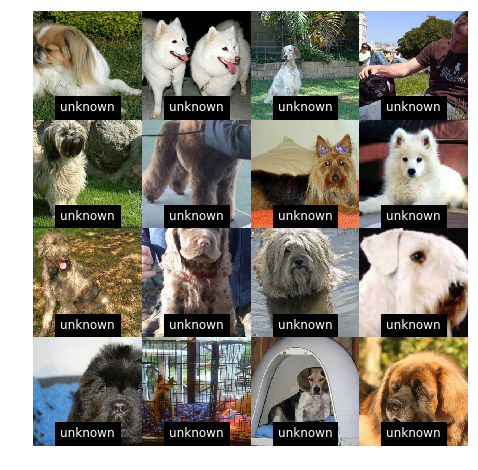

In [9]:
for batch_idx, batch_data in enumerate(test_data_loader_aug):
    print(batch_idx, batch_data['image'].size())
    print(batch_data['id'][0])
    show_data_batch(batch_data, figsize=(8, 8), train=False)
    break

### also check your device

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('you are using device: ', device)

you are using device:  cuda:0


## initialize the model

In [11]:
# Initialize the model for this run
model_ft = initialize_model(
    model_name=model_name, num_classes=num_classes, feature_extract=feature_extract, 
    use_pretrained=True)

# Send the model to GPU
model_ft = model_ft.to(device)

In [12]:
# Print the model we just instantiated
print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

## load your model weights

In [25]:
model_ft.load_state_dict(torch.load('model/dog_breed_fe_adam_10epoch_simple_0.001.pt'))

## apply on validation set (for debug) and test set

In [26]:
# define your loss type
logloss_criterion = torch.nn.CrossEntropyLoss()

# reproduce val log loss
# test time aug for 5 times: final loss: 0.7037
# for 10 times: final loss: 0.6984
val_results = apply_model(
    model=model_ft, criterion=logloss_criterion, device=device, 
    data_loader=val_data_loader, in_notebook=True, val=True, test_time_aug=False, aug_times=5)

Epoch 0/0
----------


Validation Loss: 0.5226 Acc: 0.8426


debug log loss using sklearn...
epoch 0 loss: 0.5226
final loss: 0.5226
Inference complete in 0m 5s


In [27]:
# apply on test set
test_results = apply_model(
    model=model_ft, criterion=logloss_criterion, device=device, data_loader=test_data_loader, 
    in_notebook=True, val=False, test_time_aug=False, aug_times=5)

Epoch 0/0
----------




Inference complete in 0m 46s


In [28]:
test_results.head()

,image_ids,probs
0,000621fb3cbb32d8935728e48679680e,"[2.6452302e-05, 7.344233e-05, 1.8031205e-06, 4..."
1,00102ee9d8eb90812350685311fe5890,"[9.513632e-06, 4.266766e-06, 4.916342e-06, 1.6..."
2,0012a730dfa437f5f3613fb75efcd4ce,"[1.5090452e-05, 0.0015872497, 2.9068278e-05, 1..."
3,001510bc8570bbeee98c8d80c8a95ec1,"[0.009060793, 0.0016788297, 1.8305162e-05, 4.5..."
4,001a5f3114548acdefa3d4da05474c2e,"[0.06328656, 0.00034450402, 1.33611575e-05, 4...."


## process the final score

In [29]:
label_mapping = pd.read_csv('processed_data/dog_breed_train_full.csv')
label_mapping = label_mapping[['breed', 'breed_label']].drop_duplicates().sort_values(
    'breed_label', ascending=True)
print(label_mapping.shape)
display(label_mapping.head())

(120, 2)


,breed,breed_label
30,affenpinscher,0
146,afghan_hound,1
15,african_hunting_dog,2
102,airedale,3
125,american_staffordshire_terrier,4


In [30]:
sample_submit = pd.read_csv('data/sample_submission.csv')
display(sample_submit.head())

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [31]:
test_scores = np.zeros((test_results.shape[0], num_classes))
print(test_scores.shape)

for i in range(test_results.shape[0]):
    test_scores[i] = test_results['probs'].values[i]

(10357, 120)


In [32]:
test_submit = test_results[['image_ids']]
test_submit.columns = ['id']
for item in label_mapping.to_dict('record'):
    test_submit[item['breed']] = test_scores[:, int(item['breed_label'])]

In [33]:
test_submit.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000026,0.000073,0.000002,0.000004,0.000002,0.000008,0.000002,0.000006,0.000007,...,0.000004,0.000003,0.000002,0.000007,0.000008,0.000002,0.000002,0.000006,0.000016,0.000041
1,00102ee9d8eb90812350685311fe5890,0.000010,0.000004,0.000005,0.000017,0.000006,0.000010,0.000002,0.000009,0.000007,...,0.000016,0.000004,0.000007,0.000007,0.000009,0.000005,0.000108,0.000005,0.000008,0.000006
2,0012a730dfa437f5f3613fb75efcd4ce,0.000015,0.001587,0.000029,0.000015,0.000006,0.000031,0.000004,0.000004,0.000051,...,0.000006,0.000057,0.000006,0.000125,0.000070,0.001174,0.000004,0.000049,0.000016,0.000026
3,001510bc8570bbeee98c8d80c8a95ec1,0.009061,0.001679,0.000018,0.000045,0.000046,0.000288,0.000001,0.000149,0.000244,...,0.000135,0.000006,0.000051,0.000018,0.000292,0.000021,0.000005,0.001460,0.000032,0.000118
4,001a5f3114548acdefa3d4da05474c2e,0.063287,0.000345,0.000013,0.000004,0.000033,0.000077,0.000065,0.000061,0.000176,...,0.000109,0.000112,0.000084,0.000086,0.000064,0.000027,0.000099,0.000139,0.000276,0.001645


In [34]:
test_submit.to_csv('results/test_submit_fe_adam_10epoch_simple_0.001.csv', index=False)